# Tracking a Panda: When Smoothers Fail
#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


## Part I - Forward–Backward Exponential smoothing

### 1. random-walk process and noise; forward exponential smoothing and running mean

The same as in `tracking_panda assignment` random-walk process and noise, same forward exponential smoothing and running mean

Parameters:
- $n$ points $= 300$
- $\sigma_w^2 = 28^2$
- $\sigma_\eta^2 = 97^2$
- Initial position $X_1 = 10$ m

In [486]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos=10):
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta

    return Xi, z

def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha

def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s

### Apply exponential smoothing and compare with true trajectory

As same as in the tracking_panda experiment

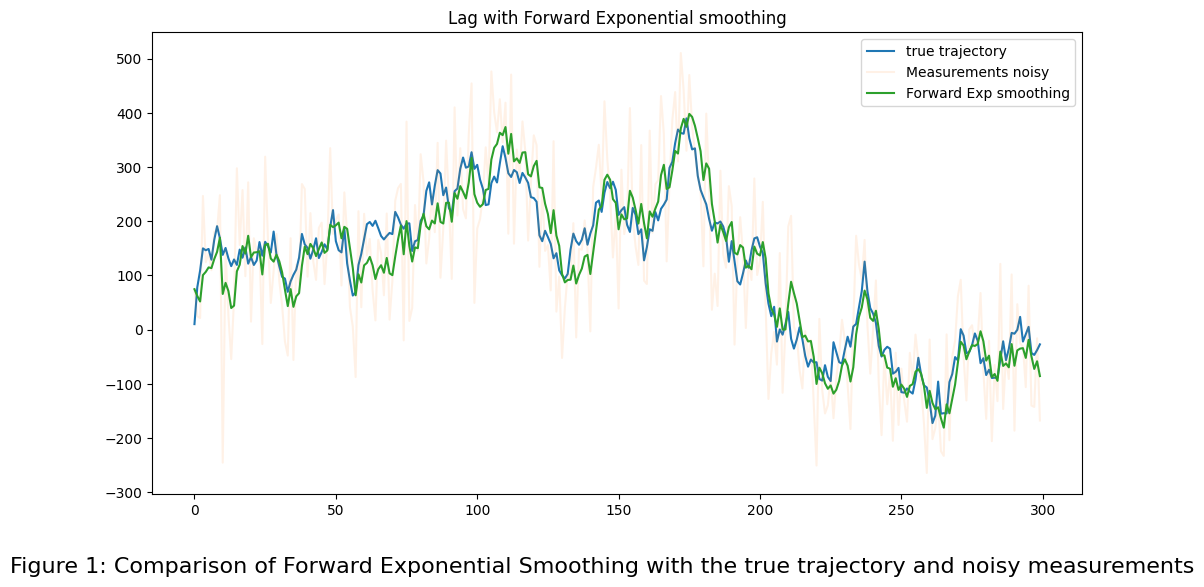

In [487]:
sigma_w2_shaky = 28**2
sigma_eta2_shaky = 97**2

alpha_shaky = calc_optimal_alpha(sigma_w2_shaky, sigma_eta2_shaky)
Xi, z = simulate_random_walk(300, sigma_w2_shaky, sigma_eta2_shaky, init_pos=10)
es_forward = exponential_smoothing(z, alpha_shaky)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.legend()
plt.title('Lag with Forward Exponential smoothing')
plt.suptitle(f'Figure {1}: Comparison of Forward Exponential Smoothing with the true trajectory and noisy measurements', fontsize=16, y=0.005)
plt.show()

Fig 1 shows that exponential smoothing involves a lag due to the high influence of the last measurement.

### 2. Backward exponential smoothing

Apply backward exponential smoothing to forward exponential smoothing curve to further reduce measurement errors

In [488]:
def forward_backward_exponential_smoothing(z, alpha):
    forward = exponential_smoothing(z, alpha)
    backward = exponential_smoothing(forward[::-1], alpha)[::-1]
    return backward

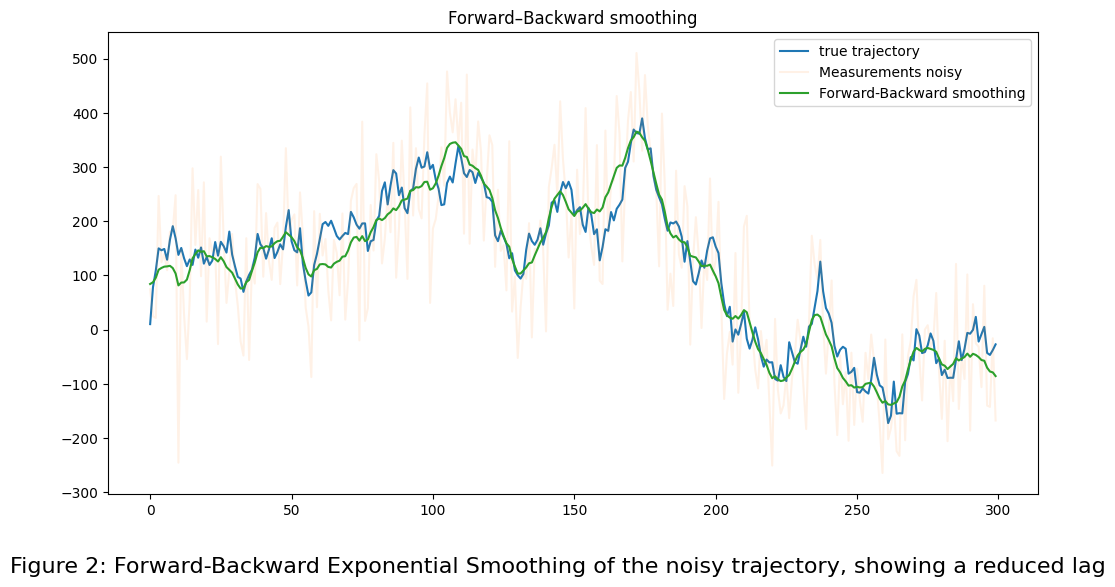

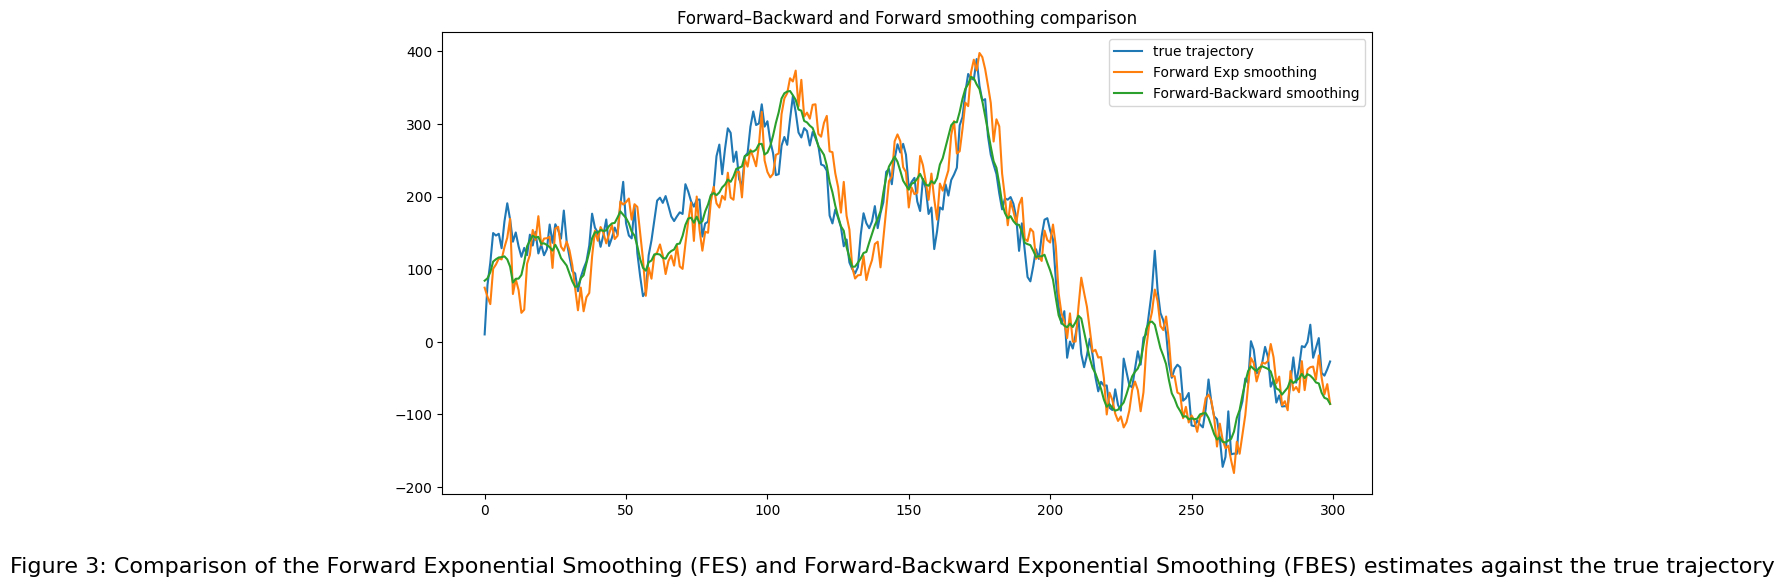

In [489]:
es_fb = forward_backward_exponential_smoothing(z, alpha_shaky)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.legend()
plt.title('Forward–Backward smoothing')
plt.suptitle(f'Figure {2}: Forward-Backward Exponential Smoothing of the noisy trajectory, showing a reduced lag', fontsize=16, y=0.005)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.legend()
plt.title('Forward–Backward and Forward smoothing comparison')
plt.suptitle(f'Figure {3}: Comparison of the Forward Exponential Smoothing (FES) and Forward-Backward Exponential Smoothing (FBES) estimates against the true trajectory', fontsize=16, y=0.005)
plt.show()

Forward-backward exponential smoothing reduces lag by smoothing data in both forward and backward directions, making it more responsive and accurate. This results in smoother, less delayed outputs, as shown in Figs 2 and 3.

### 3. Compare methods visually

In [490]:
def running_mean(data, window_size):
    if len(data) < window_size:
        return []

    N = len(data)
    smoothed = np.zeros(N)

    for i in range(N):
        smoothed[i] = np.mean(data[max(0, i - (window_size - 1) // 2):min(N, i + (window_size - 1) // 2)])

    return smoothed

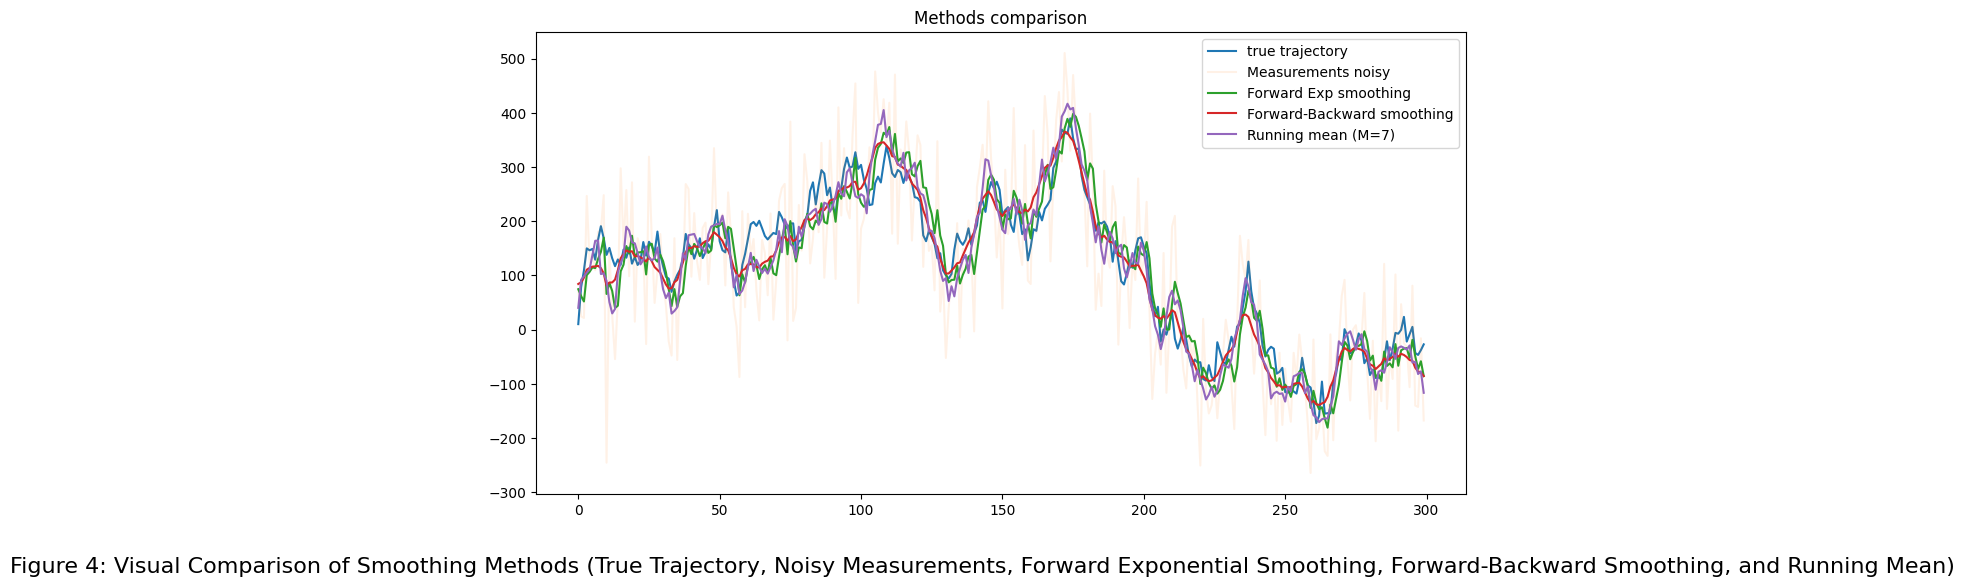

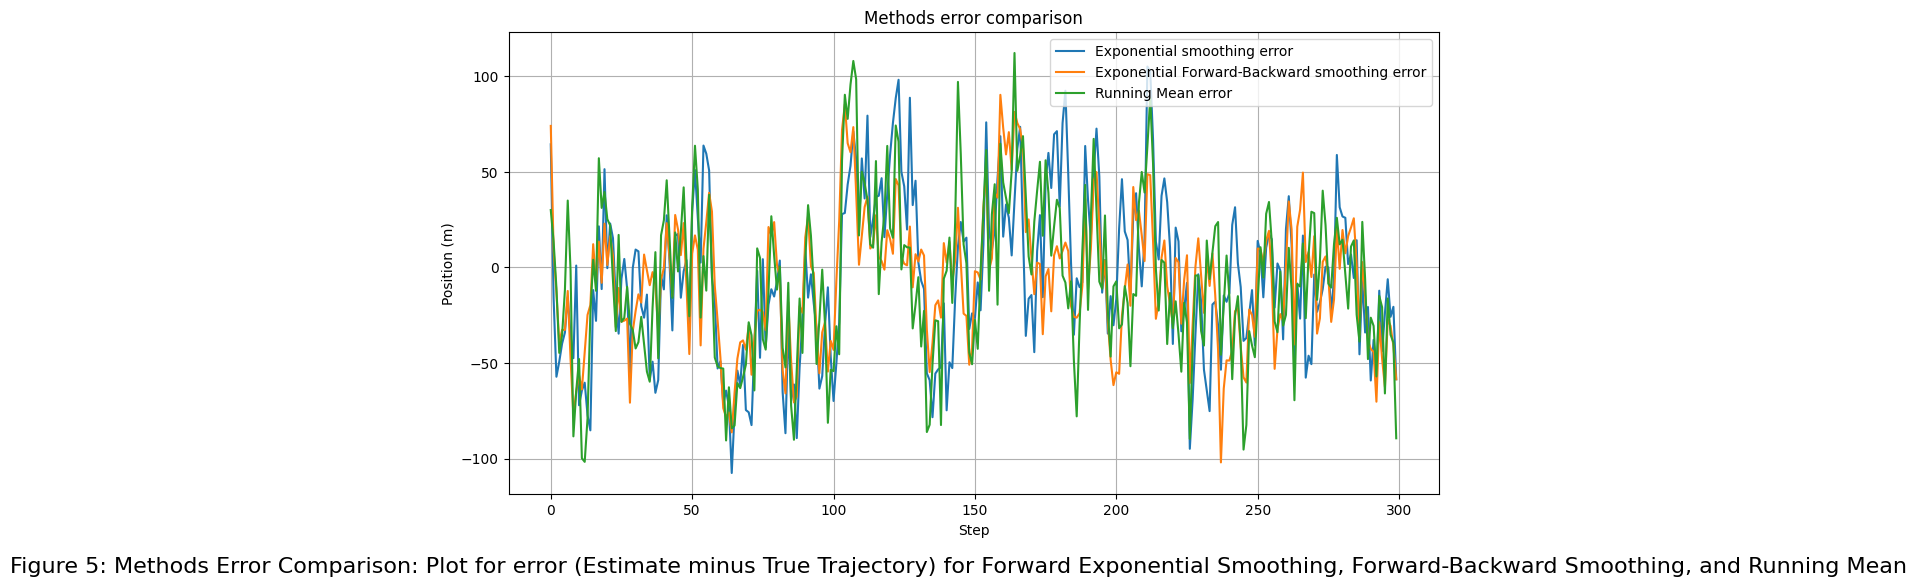

In [491]:
M = round((2 - alpha_shaky) / alpha_shaky)
rm = running_mean(z, M)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.plot(rm, label=f'Running mean (M={M})')
plt.legend()
plt.title('Methods comparison')
plt.suptitle(f'Figure {4}: Visual Comparison of Smoothing Methods (True Trajectory, Noisy Measurements, Forward Exponential Smoothing, Forward-Backward Smoothing, and Running Mean) ', fontsize=16, y=0.005)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(es_forward - Xi, label='Exponential smoothing error')
plt.plot(es_fb - Xi, label='Exponential Forward-Backward smoothing error')
plt.plot(rm - Xi, label='Running Mean error')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Methods error comparison')
plt.suptitle(f'Figure {5}: Methods Error Comparison: Plot for error (Estimate minus True Trajectory) for Forward Exponential Smoothing, Forward-Backward Smoothing, and Running Mean', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

Fig 5 clearly shows that the error of forward-backward exponential smoothing is smaller than that of other methods.

In [492]:
def calculate_indicators(data, true_data):
    I_d = np.sum((true_data - data) ** 2)
    N = len(data)
    I_v = np.sum((data[2:N] - 2 * data[1:N-1] + data[0:N-2]) ** 2)

    return I_d, I_v

I_d_f, I_v_f = calculate_indicators(es_forward, Xi)
I_d_fb, I_v_fb = calculate_indicators(es_fb, Xi)
I_d_rm, I_v_rm = calculate_indicators(rm, Xi)

print(f"Forward Exp smoothing:      Deviation Indicator I_d = {I_d_f:6.0f}, Variability Indicator I_v = {I_v_f:6.0f}")
print(f"Forward-Backward smoothing: Deviation Indicator I_d = {I_d_fb:6.0f}, Variability Indicator I_v = {I_v_fb:6.0f}")
print(f"Running mean (M={M}):         Deviation Indicator I_d = {I_d_rm:6.0f}, Variability Indicator I_v = {I_v_rm:6.0f}")

Forward Exp smoothing:      Deviation Indicator I_d = 531897, Variability Indicator I_v = 514444
Forward-Backward smoothing: Deviation Indicator I_d = 365200, Variability Indicator I_v =  17242
Running mean (M=7):         Deviation Indicator I_d = 518640, Variability Indicator I_v = 345068


Forward-Backward Exponential Smoothing (FBES) is the best method. It yields the lowest Deviation Indicator I_d confirming the best accuracy because the backward pass corrects the significant lag error present in Forward Exponential Smoothing (FES). Furthermore, FBES typically results in a very low Variability Indicator (I_v) due to its inherent double-smoothing process, providing the smoothest and most accurate estimate against the true trajectory.

## Part II. A. "Sun-nap stroll": Slow Motion, Heavy Noise

### 1. Simulate panda motion with slowly changing velocity and compare running mean and exponential smoothing.

In [503]:
def simulate_sun_nap(n_points=300, T=0.1, sigma_a2=10, sigma_eta2=500):
    a = np.random.normal(0, np.sqrt(sigma_a2), n_points)
    X = np.zeros(n_points)
    V = np.zeros(n_points)
    X[0], V[0] = 5, 0
    for i in range(1, n_points):
        X[i] = X[i-1] + V[i-1]*T + 0.5*a[i-1]*T**2
        V[i] = V[i-1] + a[i-1]*T
    eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
    z = X + eta
    return X, z

X_true, z = simulate_sun_nap()

### 2. Experiments

Empirically determine the optimal window size $𝑀$ for the running mean and the smoothing coefficient for forward exponential smoothing to achieve the best estimation of the panda’s motion using the measurements $𝑧_𝑖$.

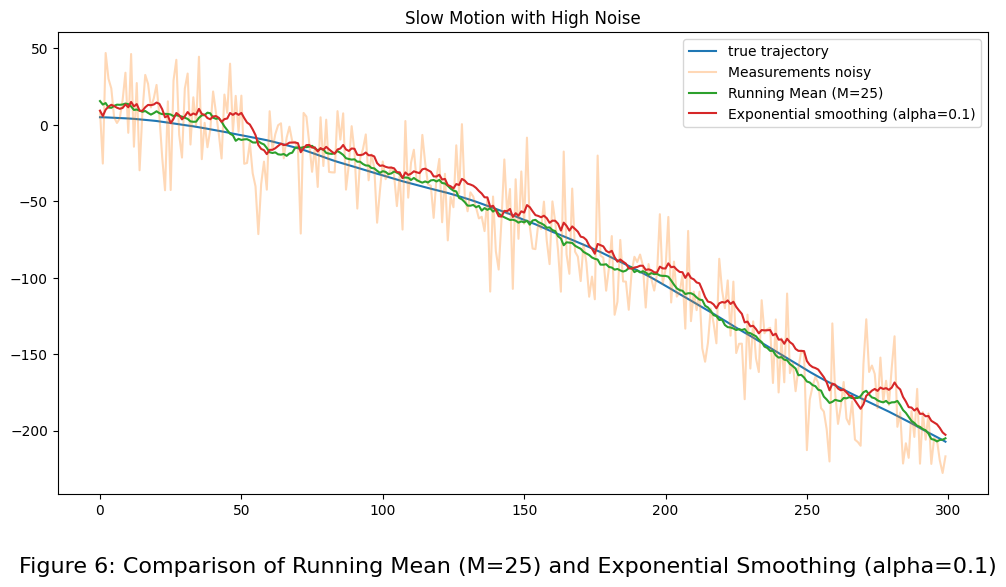

In [494]:
M_opt = 25  # Empirically chosen window size
rm_est = running_mean(z, M_opt)

alpha_test = 0.1  # Empirically chosen smoothing coefficient
es_est = exponential_smoothing(z, alpha_test)

plt.figure(figsize=(12,6))
plt.plot(X_true, label='true trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
plt.plot(rm_est, label=f'Running Mean (M={M_opt})')
plt.plot(es_est, label=f'Exponential smoothing (alpha={alpha_test})')
plt.legend()
plt.title('Slow Motion with High Noise')
plt.suptitle(f'Figure {6}: Comparison of Running Mean (M=25) and Exponential Smoothing (alpha=0.1)', fontsize=16, y=0.005)
plt.show()

The values for M and alpha were chosen based on the experiments. 
• M=25 window size was selected to perform noise reduction by averaging noisy points, but without introducing extra smoothing and signal loosing.
• alpha = 0.1 was chosen to give a reasonable weight to the new measurement, keeping balance between variability and deviation.

### 3. Most effective smoothing method based on deviation and variability indicators. Conclusion

In [504]:
for alpha_test in [0.01, 0.03, 0.05, 0.1, 0.2, 0.4, 0.6]:
    es_est = exponential_smoothing(z, alpha_test)
    I_d = np.sum((X_true - es_est) ** 2)
    N = len(es_est)
    I_v = np.sum((es_est[2:N] - 2 * es_est[1:N-1] + es_est[0:N-2]) ** 2)

    print(f"alpha = {alpha_test:.2f}: Deviation Indicator I_d = {I_d:6.0f}, Variability Indicator I_v = {I_v:4.0f}")

alpha = 0.01: Deviation Indicator I_d =  43320, Variability Indicator I_v =   36
alpha = 0.03: Deviation Indicator I_d =  10428, Variability Indicator I_v =  332
alpha = 0.05: Deviation Indicator I_d =   6653, Variability Indicator I_v =  941
alpha = 0.10: Deviation Indicator I_d =   8321, Variability Indicator I_v = 3957
alpha = 0.20: Deviation Indicator I_d =  16799, Variability Indicator I_v = 17516
alpha = 0.40: Deviation Indicator I_d =  38071, Variability Indicator I_v = 86153
alpha = 0.60: Deviation Indicator I_d =  67806, Variability Indicator I_v = 240237


In exponential smoothing, higher α gives more weight to new data and increases curve variability, while lower α smooths more but may lag.
From the results, variability indicator increases strongly with α.
The smallest deviation appears at α = 0.10.
We can say, that the most balanced values occur between α = 0.05 and α = 0.10, where deviation remains low and variability is still moderate, offering a reasonable compromise between accuracy and smoothness.

In [506]:
for window_size in [10, 20, 30, 50, 70, 100, 150, 200]:
    rm_est = running_mean(z, window_size)
    I_d = np.sum((X_true - rm_est) ** 2)
    N = len(rm_est)
    I_v = np.sum((rm_est[2:N] - 2 * rm_est[1:N-1] + rm_est[0:N-2]) ** 2)

    print(f"window_sizse = {window_size:3d}: Deviation Indicator I_d = {I_d:6.0f}, Variability Indicator I_v = {I_v:4.0f}")

window_sizse =  10: Deviation Indicator I_d =  18785, Variability Indicator I_v = 11044
window_sizse =  20: Deviation Indicator I_d =  10164, Variability Indicator I_v = 2480
window_sizse =  30: Deviation Indicator I_d =   6036, Variability Indicator I_v =  969
window_sizse =  50: Deviation Indicator I_d =   2745, Variability Indicator I_v =  287
window_sizse =  70: Deviation Indicator I_d =   2088, Variability Indicator I_v =  131
window_sizse = 100: Deviation Indicator I_d =   2233, Variability Indicator I_v =   68
window_sizse = 150: Deviation Indicator I_d =   2793, Variability Indicator I_v =   32
window_sizse = 200: Deviation Indicator I_d =   5491, Variability Indicator I_v =   19


From the results, variability indicator decreases strongly with window size. For small windows (10–20), deviation is high and the curve is too jagged.  
For very large windows (150–200), variability is very low but deviation becomes excessive, losing accuracy.  
The best compromise occurs around window size = 70–100, where deviation is relatively low and variability is already small, giving an effective balance between smoothness and accuracy.


These results are better than those for exponential smoothing, and we can conclude that a running mean with a window of 70-100 is the best solution.

# Part II. B. Cyclic Motion in Rolling Bamboo Hills

### 4. Generate a cyclic trajectory $𝑋_𝑖$. Generate measurements $𝑧_𝑖$ of the panda’s cyclic motion $𝑋_𝑖$

In [497]:
n_points = 200
T = 32
sigma_w2 = 0.08**2
sigma_eta2 = 0.05
M = 13

def generate_cyclic_motion(T, n_points):
    omega = 2 * np.pi / T

    A = np.zeros(n_points)
    X = np.zeros(n_points)
    A[0] = 1.0

    for i in range(1, n_points):
        wi = np.random.normal(0, np.sqrt(sigma_w2))
        A[i] = A[i-1] + wi
        X[i] = A[i] * np.sin(omega * i + 3)

    eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
    z = X + eta

    return X, z

X_cyclic, z_cyclic = generate_cyclic_motion(T, n_points)

### 5. Apply running mean with a window size of $𝑀 = 13$ to the measurements

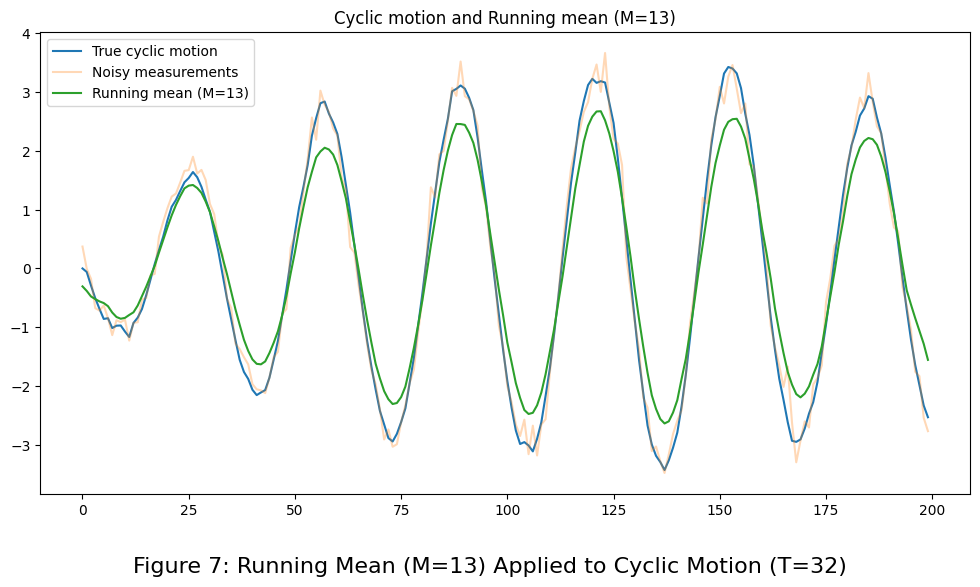

In [498]:
rm = running_mean(z_cyclic, M)

plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='True cyclic motion')
plt.plot(z_cyclic, alpha=0.3, label='Noisy measurements')
plt.plot(rm, label=f'Running mean (M={M})')
plt.legend()
plt.title('Cyclic motion and Running mean (M=13)')
plt.suptitle(f'Figure {7}: Running Mean (M=13) Applied to Cyclic Motion (T=32)', fontsize=16, y=0.005)
plt.show()

Fig 7 visually shows that window size == 13 describes the dynamics quite well.

#### Experiments with running mean window size

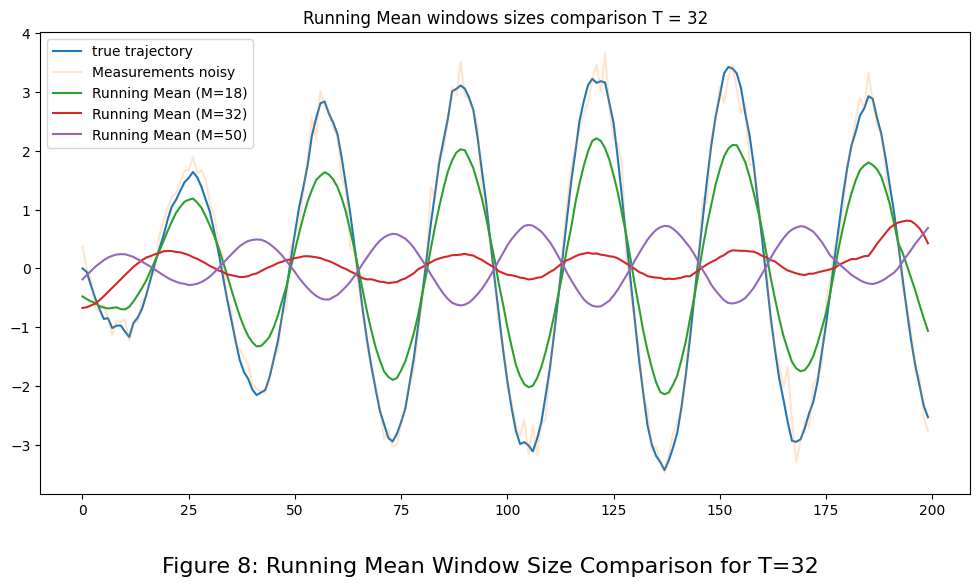

In [499]:
plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='true trajectory')
plt.plot(z_cyclic, alpha=0.2, label='Measurements noisy')
for M in [18, 32, 50]:
    rm = running_mean(z_cyclic, M)
    plt.plot(rm, label=f'Running Mean (M={M})')
plt.legend()
plt.title('Running Mean windows sizes comparison T = 32')
plt.suptitle(f'Figure {8}: Running Mean Window Size Comparison for T=32', fontsize=16, y=0.005)
plt.show()

It is clear that choosing the window size without careful consideration leads to incorrect results. The window size must be selected optimally. Here M = 18 has the best results

### 6. Oscillation Period Analysis

Test how the running mean with window size 13 affects signals with different periods.

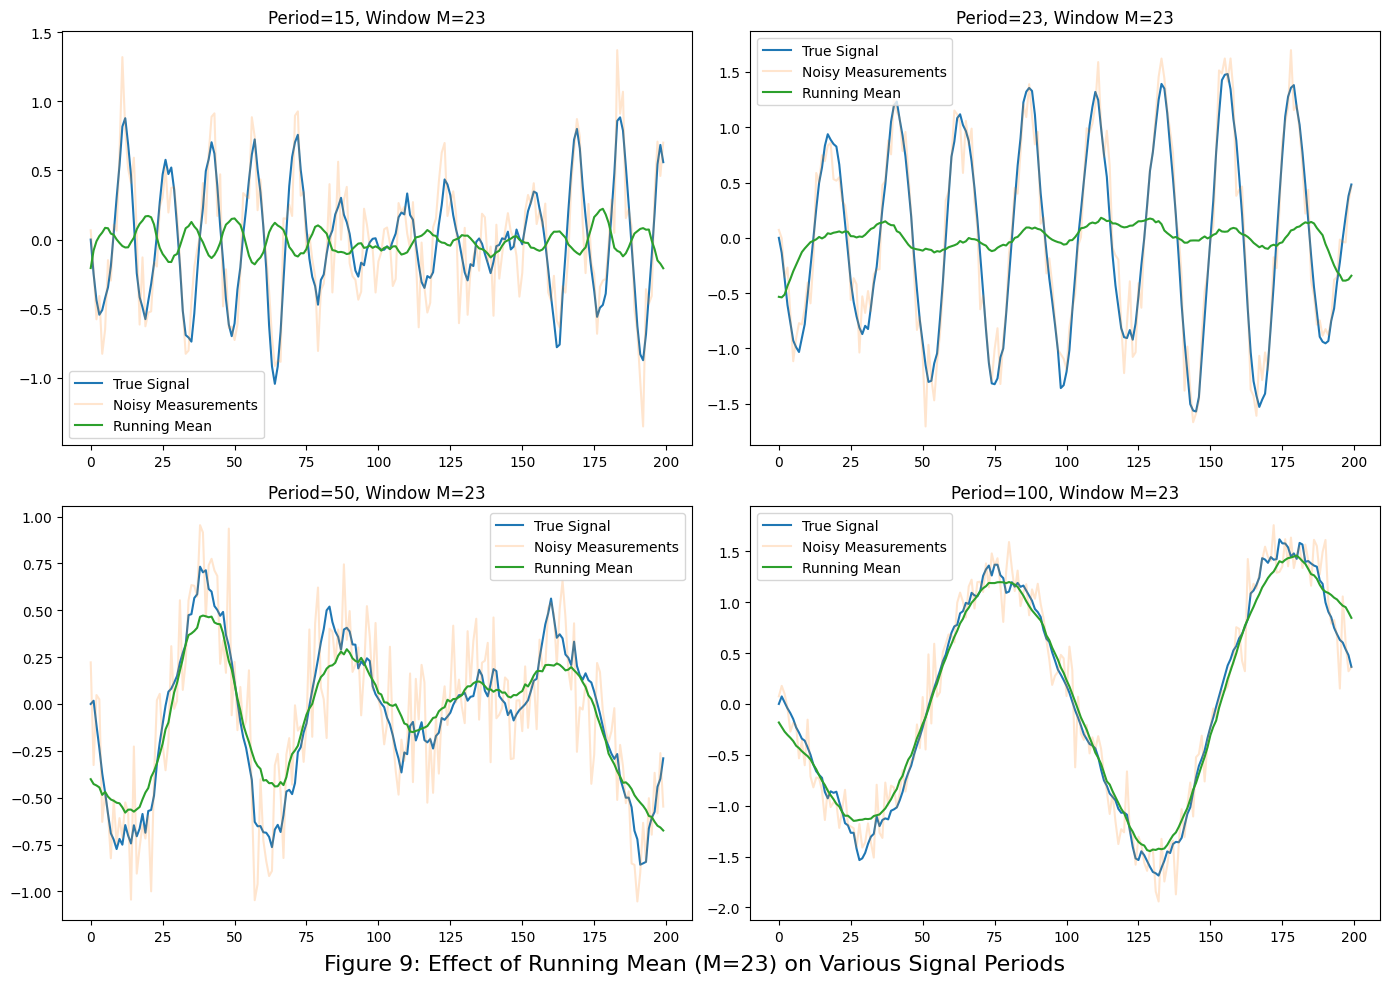

In [500]:
M = 23
periods = [15, 23, 50, 100]
plt.figure(figsize=(14,10))
for idx, period in enumerate(periods, 1):
    X, z = generate_cyclic_motion(T=period, n_points=200)
    rm = running_mean(z, M)
    plt.subplot(2,2,idx)
    plt.plot(X, label='True Signal')
    plt.plot(z, alpha=0.2, label='Noisy Measurements')
    plt.plot(rm, label='Running Mean')
    plt.title(f'Period={period}, Window M={M}')
    plt.legend()

plt.suptitle(f'Figure {9}: Effect of Running Mean (M=23) on Various Signal Periods', fontsize=16, y=0.005)
plt.tight_layout()
plt.show()

### Conclusions
When the period is much smaller than the window size, the running mean causes inverse oscillations due to signal aliasing.  
When the period is close to the window size, running mean can eliminate oscillations.  
When the period is larger than the window size, the running mean smooths noise but can retain oscillation shape.  

Therefore, the running mean window size relative to the oscillation period critically affects the output.

#### Additional. Experiments with Forward-Backward Exponential smoothing alpha coefficient

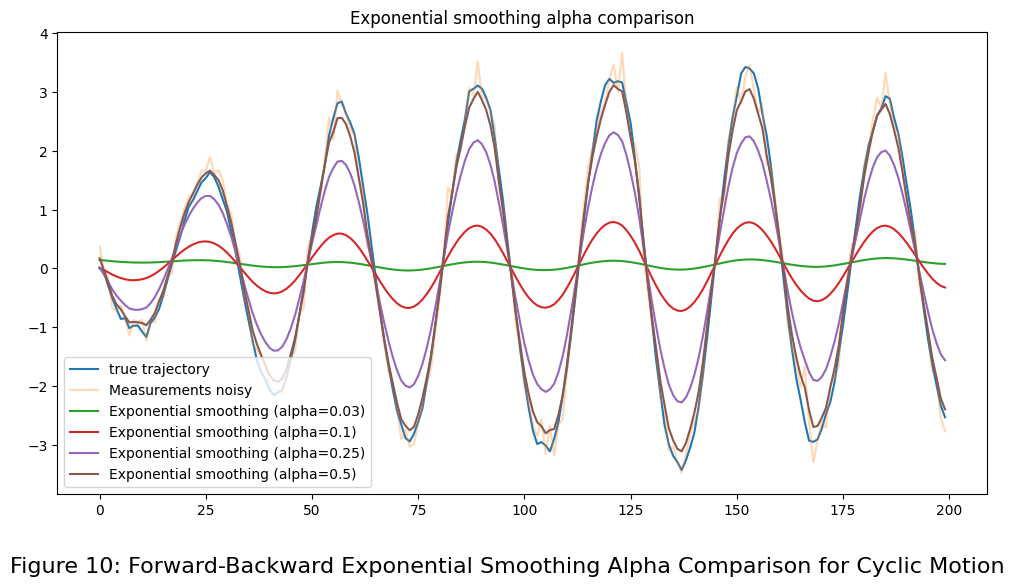

In [501]:
plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='true trajectory')
plt.plot(z_cyclic, alpha=0.3, label='Measurements noisy')
for alpha in [0.03, 0.1, 0.25, 0.5]:
    es_est = forward_backward_exponential_smoothing(z_cyclic, alpha)
    plt.plot(es_est, label=f'Exponential smoothing (alpha={alpha})')
plt.legend()
plt.title('Exponential smoothing alpha comparison')
plt.suptitle(f'Figure {10}: Forward-Backward Exponential Smoothing Alpha Comparison for Cyclic Motion', fontsize=16, y=0.005)
plt.show()

Similar to the window size, the alpha coefficient must be selected appropriately, otherwise the data will either be lost or will not make sense. Deviation and variability indicators can help in the selection process.

### Learning Log

| Aspect | Reflection / Learning Outcome |
|---|---|
| Smoothing | Learned how running mean and exponential smoothing help minimize noise and how backward smoothing can minimize lag caused by forward exponential smoothing |
| Parameter Tuning | Understood how varying the smoothing coefficient or window size affects accuracy and smoothness of results |
| Observations from Scenarios | Observed that correctly chosed methods works well for different scenarious. However, if an incorrect parameters are used, the result may be completely false |
| Overall Learning | Understood the advantages and limitations of each smoothing method and how to balance noise reduction and smoothness |